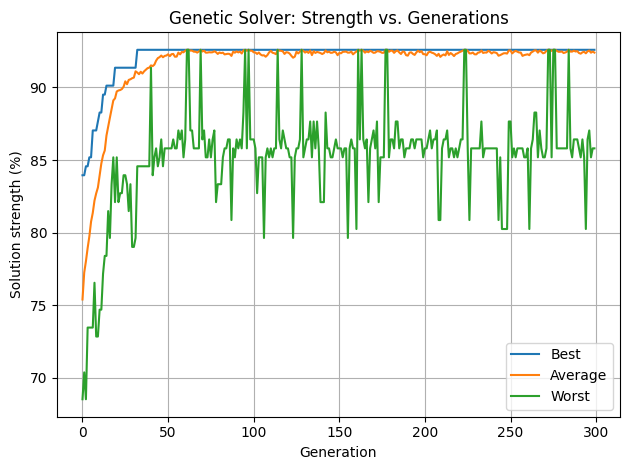

No solution found.
-------------------------
| . . 8 | . 5 6 | . . . |
| 7 . 4 | . . . | 6 1 9 |
| . . . | . . . | 8 5 . |
|-------+-------+-------|
| 6 . 7 | . 2 9 | 5 . . |
| . . 9 | . 6 . | 1 . . |
| . . 2 | 3 1 . | 9 . 4 |
|-------+-------+-------|
| . 3 5 | . . . | . . . |
| 4 2 1 | . . . | 3 . 6 |
| . . . | 8 3 . | 4 . . |
-------------------------


In [72]:
from __future__ import annotations
import random
import math
import os
from typing import List,Set, Tuple
import matplotlib.pyplot as plt


# Parameters
GROUP_ID: str = 'Group29'
ALGORITHM: str = 'ga'
PUZZLE_TYPE: str = 'easy'
PUZZLE_PATH: str = 'puzzles/Easy-P1.txt'

EMPTY_VALUE: int = 0  # Note this value is somewhat arbitrary, but this seems to work well
FULL_MASK: int = 511 # The value of a full bitset, that is all values (1...9) set

class Board:
    def __init__(self, print_info: bool = True, write_to_file: bool = True, solve: bool = True, import_from_file: bool = True):
        self.puzzle: List[List[int]] = [[EMPTY_VALUE]*9 for _ in range(9)]  # Stores the original puzzle
        self.state: List[List[int]] = [[EMPTY_VALUE]*9 for _ in range(9)]   # Stores the current board state

        """
        Its useful to store rows columns and squares inside "bitsets" where each value is a set of 9 booleans, one for each value (1...9).
        Then when checking for whether a number can be put in a cell, it is just bitwise or operations, which are very fast.
        """

        # map 1..9 -> bits 0..8
        self.row_masks = [0]*9
        self.col_masks = [0]*9
        self.square_masks = [0]*9
        self.solved = False

        if import_from_file:
            try:
                self.get_puzzle(PUZZLE_PATH)  # Pulls in the puzzle from a file
            except FileNotFoundError:
                print('Puzzle file not found')
                return

            for row in range(9):  # Copies the puzzle into the board state
                for col in range(9):
                    self.set_cell(row, col, self.puzzle[row][col])

        if solve:
            match ALGORITHM:  # Selects the correct solver object
                case 'bt':
                    self.solver: BacktrackingSolver = BacktrackingSolver(self)
                case 'fc':
                    self.solver: ForwardCheckingSolver = ForwardCheckingSolver(self)
                case 'ac3':
                    self.solver: AC3Solver = AC3Solver(self)
                case 'sa':
                    self.solver: SimulatedAnnealingSolver = SimulatedAnnealingSolver(self)
                case 'ga':
                    self.solver: GeneticSolver = GeneticSolver(self)
                case _:
                    print('Unknown algorithm')
                    return

            self.solver.solve()  # Runs the solver

            if self.check_solution():
                if print_info:
                    print("Solved!")
                    self.pretty_print()
                    print(f"Solution decision count: {self.solver.decision_count}")
                if write_to_file:
                    print(f"Solution stored at {self.output_puzzle_file()}")
                self.solved = True
            else:
                if print_info:
                    print("No solution found.")
                    self.pretty_print()

    def __str__(self) -> str:
        """
        :return: The format is the same as the input file
        """
        out: List[str] = []
        for line in self.state:
            out.append(','.join(str(c) if c != EMPTY_VALUE else '?' for c in line))
        return '\n'.join(out) + '\n'

    def pretty_print(self):
        """
        Prints this board in a human-readable form, with seperated squares
        """
        print("-"*25)
        for r in range(9):
            if r % 3 == 0 and r != 0:
                print("|"+'+'.join(["-"*7 for _ in range(3)])+"|")  # horizontal separator

            row_str = "| "
            for c in range(9):
                if c % 3 == 0 and c != 0:
                    row_str += "| "
                val = self.state[r][c]
                row_str += (str(val) if val != EMPTY_VALUE else ".") + " "
            print(row_str.strip()+" |")
        print("-"*25)

    def copy(self, board: Board):
        for row in range(9):
            for col in range(9):
                self.set_cell(row, col, board.get_cell(row, col))

    def get_cell(self, row: int, col: int) -> int:
        return self.state[row][col]

    def get_row(self, row: int) -> List[int]:
        return self.state[row]

    def get_col(self, col: int) -> List[int]:
        return [row[col] for row in self.state]

    def get_square(self, squareid: int) -> List[int]:
        """
        Gets one of the 9 3x3 squares on the Sudoku puzzle
        :param squareid: a value 0...8 representing the square
        :return: the values of the square in a list
        """
        r0 = (squareid // 3) * 3
        c0 = (squareid % 3) * 3
        return [self.state[r][c] for r in range(r0, r0 + 3) for c in range(c0, c0 + 3)]


    def set_square(self, squareid: int, values: List[int]):
        r0 = (squareid // 3) * 3
        c0 = (squareid % 3) * 3
        # clear existing cells in the square from masks/state
        for row in range(r0, r0 + 3):
            for col in range(c0, c0 + 3):
                self.clear_cell(row, col)
        # set new values with mask updates
        i = 0
        for row in range(r0, r0 + 3):
            for col in range(c0, c0 + 3):
                value = values[i]
                if value != EMPTY_VALUE:
                    self.set_cell(row, col, value)
                i += 1



    def set_cell(self, row: int, col: int, value: int):
        self.clear_cell(row, col)
        self.state[row][col] = value
        if value != EMPTY_VALUE:
            bit = 1 << (value - 1)  # map 1..9 -> bits 0..8
            self.row_masks[row] |= bit
            self.col_masks[col] |= bit
            self.square_masks[(row//3)*3 + (col//3)] |= bit

    def clear_cell(self, row: int, col: int):
        original_value = self.state[row][col]
        if original_value != EMPTY_VALUE:
            bit = 1 << (original_value - 1)
            self.row_masks[row] &= ~bit
            self.col_masks[col] &= ~bit
            self.square_masks[(row//3)*3 + (col//3)] &= ~bit
        self.state[row][col] = EMPTY_VALUE

    def swap_cells(self, row1: int, col1: int, row2: int, col2: int):
        """
        Swaps two given cells
        """
        value1,value2 = self.get_cell(row1, col1), self.get_cell(row2, col2)
        self.set_cell(row2, col2, value1)
        self.set_cell(row1, col1, value2)

    def get_row_mask(self, row: int) -> int:
        return self.row_masks[row]

    def get_col_mask(self, col: int) -> int:
        return self.col_masks[col]

    def get_square_mask(self, row: int, col: int) -> int:
        return self.square_masks[(row//3)*3 + (col//3)]

    def get_cell_mask(self, row: int, col: int) -> int:
        """
        Returns the combination of the row, column, and square constrains in a single bitset (integer)
        """
        cell_mask = self.get_row_mask(row)
        cell_mask |= self.get_col_mask(col)
        cell_mask |= self.get_square_mask(row, col)
        return cell_mask

    def get_puzzle(self, filename: str):
        """
        Throws fileNotFound exception
        :param filename: Takes in a file name of a puzzle file
        Sets this board to the puzzle given in the file
        """
        with open(filename) as f:
            for y, line in enumerate(f.readlines()):
                for x, value in enumerate(line.split(',')):
                    value = value.strip()
                    if not value.isnumeric():
                        self.puzzle[y][x] = EMPTY_VALUE
                    else:
                        self.puzzle[y][x] = int(value)

    def output_puzzle_file(self) -> str:
        puzzle_name = ""
        for ch in reversed(PUZZLE_PATH):
            if ch in ('/', '\\'):
                break
            puzzle_name = ch + puzzle_name
        puzzle_name = puzzle_name.split('.')[0]  # Removes txt extension

        os.makedirs('output', exist_ok=True) # Makes sure output directory exists
        outfile_name = f'output/{GROUP_ID}_{ALGORITHM}_{PUZZLE_TYPE}_{puzzle_name}.txt'
        with open(outfile_name, 'w') as f:
            f.write(str(self))
        return outfile_name

    def check_solution(self) -> bool:
        """
        Separate checker from the solvers themselves, to ensure puzzles are correct.
        Not very optimized, but it doesn't really matter because it runs once per puzzle.
        :return: True is solved, False otherwise
        """
        # 1) No empties
        values: set[int] = set()
        for row in self.state:
            values.update(row)
        if EMPTY_VALUE in values:
            return False

        values = set()
        # 2) Rows and columns contain 9 distinct values (Sudoku assumes 1..9)
        for i in range(9):
            row = set(self.get_row(i))
            col = set(self.get_col(i))
            if len(row) != 9:
                return False
            if len(col) != 9:
                return False

            values = values.union(row)

            # 3) Each 3x3 square distinct
            r0 = (i // 3) * 3
            c0 = (i % 3) * 3
            square = [self.state[r][c] for r in range(r0, r0+3) for c in range(c0, c0+3)]
            if len(set(square)) != 9:
                return False

        # 4) Only legal values in the board (1...9)
        if len(values.intersection(set(range(1, 10)))) != 9:
            return False

        # 5) All original tiles from the puzzle are preserved
        for row in range(9):
            for col in range(9):
                if self.puzzle[row][col] != EMPTY_VALUE and self.state[row][col] != self.puzzle[row][col]:
                    return False

        return True




class BacktrackingSolver:
    def __init__(self, board: Board):
        self.decision_count: int = 0
        self.board: Board = board
        self.empty_squares: List[Tuple[int, int]] = [] # A list of all squares that need to be filled
        self.counted_numbers = {} # Counted values used in the puzzle so far, up to 9 of each (1...9) ignores empty squares
        self.get_all_empty()
        self.count_board_values()

    def get_all_empty(self):
        """
        Stores all empty squares into self.empty_squares
        """
        for row in range(9):
            for col in range(9):
                if self.board.state[row][col] == EMPTY_VALUE:
                    self.empty_squares.append((row, col))

    def count_board_values(self):
        """
        Count used values and store them in self.counted_numbers
        """
        self.counted_numbers = {i:0 for i in range(1, 10)}
        for row in range(9):
            for col in range(9):
                value = self.board.get_cell(row, col)
                if value != EMPTY_VALUE:
                    self.counted_numbers[value] += 1

    def sorted_values_by_use(self):
        return sorted(self.counted_numbers.items(),key=lambda x: x[1])

    def get_mrv(self) -> Tuple[int, int]:
        """
        mrv: most restricted value
        Look into the empty squares list, and finds the one with the most restrictions
        :return: Returns the mrv and pops it off the empty squares list
        """
        cell_index = -1
        best_restriction_count = -1

        for i, cell in enumerate(self.empty_squares):
            row, col = cell
            restriction_count = self.board.get_cell_mask(row, col).bit_count()

            if restriction_count > best_restriction_count:
                best_restriction_count = restriction_count
                cell_index = i
        return self.empty_squares.pop(cell_index)

    def solve(self) -> bool:
        """
        Solves the puzzle using backtracking. With a couple heuristics:
        1. mrv, start with whatever cell is the most restricted i.e. can only be a few values.
                This ensures that the DFS tree has as few starting branches as possible.
        2. least used value, start with the values that are least used in the puzzle so far:
                This limits the rest of the puzzle as minimally as possible.
        :return: Return the success of the solving algorithm
        """
        if len(self.empty_squares) == 0:
            return True

        row, col = self.get_mrv()
        for digit,_ in self.sorted_values_by_use():
            self.counted_numbers[digit] += 1
            self.decision_count += 1  # count each attempted assignment
            if self.is_digit_possible(row, col, digit):
                self.board.set_cell(row, col, digit)
                if self.solve():
                    return True
                self.board.clear_cell(row, col)
            self.counted_numbers[digit] -= 1
        self.empty_squares.append((row, col))
        return False

    def is_digit_possible(self, row: int, col: int, digit: int) -> bool:
        """
        Uses bitwise logic to quickly determine if a digit can go into a square.
        """
        bit = 1 << (digit - 1)
        return bool(bit & (~self.board.get_cell_mask(row, col)))

class ForwardCheckingSolver:
    def __init__(self, board: Board):
        self.decision_count: int = 0
        self.board: Board = board
        self.cell_domains: List[List[int]] = [[0 for _ in range(9)] for _ in range(9)] # Bitsets for each cell in the puzzle, map 1..9 -> bits 0..8
        self.init_domains()
        self.empty_squares: Set[Tuple[int, int]] = set() # All squares that are empty in the puzzle before solving
        self.init_empty_squares()
        self.counted_numbers = {i:0 for i in range(1,10)} # Counted values used in the puzzle so far, up to 9 of each (1...9) ignores empty squares
        self.init_counted_numbers()

    def init_empty_squares(self):
        for row in range(9):
            for col in range(9):
                if self.board.get_cell(row,col) == EMPTY_VALUE:
                    self.empty_squares.add((row, col))

    def init_domains(self):
        for row in range(9):
            for col in range(9):
                self.cell_domains[row][col] = FULL_MASK & (~self.board.get_cell_mask(row, col))

    def init_counted_numbers(self):
        for row in range(9):
            for col in range(9):
                value = self.board.get_cell(row, col)
                if value != EMPTY_VALUE:
                    self.counted_numbers[value] += 1

    def sorted_values_by_use(self) -> List[Tuple[int, int]]:
        return sorted(self.counted_numbers.items(),key=lambda x: x[1])

    def update_domains(self, start: Tuple[int, int]) -> bool:
        row, col = start

        # Top left of the square containing the start value
        r0 = (row // 3) * 3
        c0 = (col // 3) * 3

        neighbors = set()

        # Row and column neighbors
        for i in range(9):
            neighbors.add((row, i))
            neighbors.add((i, col))

        # Box neighbors
        for dr in range(3):
            for dc in range(3):
                neighbors.add((r0 + dr, c0 + dc))

        valid_board = True
        # Update domains for each cell
        for r, c in neighbors:
            value = FULL_MASK & (~self.board.get_cell_mask(r, c))
            if value == 0 and (r,c) in self.empty_squares:
                valid_board = False
            self.cell_domains[r][c] = value

        return valid_board

    def get_mrv(self) -> Tuple[int, int]:
        """
        mrv: most restricted value
        Looks into the cell domains and finds the one with the most restrictions
        :return: Returns the mrv and pops it off the empty squares list
        """
        best_value = 99
        best_cell = None
        for cell in self.empty_squares:
            domain_size = self.cell_domains[cell[0]][cell[1]].bit_count()
            if domain_size < best_value:
                best_value = domain_size
                best_cell = cell
        self.empty_squares.remove(best_cell)
        return best_cell

    def solve(self) -> bool:
        if len(self.empty_squares) == 0:
            return True
        row,col = self.get_mrv()
        for value,_ in self.sorted_values_by_use():
            if not bool((1<<(value-1))&self.cell_domains[row][col]):
                continue
            self.board.set_cell(row, col, value)
            if self.update_domains((row,col)):
                self.decision_count += 1
                self.counted_numbers[value] += 1
                if self.solve():
                    return True
            self.counted_numbers[value] -= 1
            self.board.clear_cell(row, col)
            self.update_domains((row,col))
        self.empty_squares.add((row, col))
        return False

class AC3Solver:
    def __init__(self, board: Board):
        self.decision_count: int = 0
        self.board: Board = board
        self.empty_squares: Set[Tuple[int, int]] = set() # All squares that are empty in the puzzle before solving
        self.init_empty_squares()
        self.cell_domains: List[List[int]] = [[0 for _ in range(9)] for _ in range(9)] # Bitsets for each cell in the puzzle, map 1..9 -> bits 0..8
        self.init_domains()
        self.counted_numbers = {i:0 for i in range(1,10)} # Counted values used in the puzzle so far, up to 9 of each (1...9) ignores empty squares
        self.init_counted_numbers()
        self.neighbors: List[List[Set[Tuple[int, int]]]] = [list() for _ in range(9)] # A lookup table for all neighbors of all cells
        self.init_neighbors()



    def init_empty_squares(self):
        for row in range(9):
            for col in range(9):
                if self.board.get_cell(row,col) == EMPTY_VALUE:
                    self.empty_squares.add((row, col))

    def init_domains(self):
        for row in range(9):
            for col in range(9):
                value = self.board.get_cell(row,col)
                if value != EMPTY_VALUE:
                    self.cell_domains[row][col] = 1<<(value-1)
                else:
                    self.cell_domains[row][col] = FULL_MASK & (~self.board.get_cell_mask(row, col))

    def init_counted_numbers(self):
        for row in range(9):
            for col in range(9):
                value = self.board.get_cell(row, col)
                if value != EMPTY_VALUE:
                    self.counted_numbers[value] += 1

    @staticmethod
    def get_neighbors_onthefly(start: Tuple[int, int], ) -> Set[Tuple[int, int]]:
        """
        Finds all neighbors of the current cell, not including the current cell
        """
        row, col = start

        # Top left of the square containing the start value
        r0 = (row // 3) * 3
        c0 = (col // 3) * 3

        neighbors = set()

        # Row and column neighbors
        for i in range(9):
            neighbors.add((row, i))
            neighbors.add((i, col))

        # Square neighbors
        for dr in range(3):
            for dc in range(3):
                neighbors.add((r0 + dr, c0 + dc))

        neighbors.discard(start)
        return neighbors

    def init_neighbors(self):
        for row in range(9):
            for col in range(9):
                self.neighbors[row].append(AC3Solver.get_neighbors_onthefly((row,col)))


    def get_neighbors(self,start: Tuple[int,int]) -> Set[Tuple[int, int]]:
        return self.neighbors[start[0]][start[1]]


    def propagate_constraints(self) -> bool:
        """
        :return: success or failure in a boolean
        """
        contradiction = False
        propagation_queue = [(r,c) for r in range(9) for c in range(9)] # Values to be checked for their domain size
        while propagation_queue and not contradiction:
            row, col = propagation_queue.pop(0)
            domain = self.cell_domains[row][col]
            domain_size = domain.bit_count()
            if domain_size == 0: # Contradiction, something went wrong
                return False
            if domain_size > 1:
                continue

            # Domain size is known to be one at this point
            for neighbor_row,neighbor_col in self.get_neighbors((row,col)):
                neighbor_domain = self.cell_domains[neighbor_row][neighbor_col]
                self.cell_domains[neighbor_row][neighbor_col] &= ~domain # Remove this value from each neighbor
                if neighbor_domain != self.cell_domains[neighbor_row][neighbor_col]: # if something changes
                    if self.cell_domains[neighbor_row][neighbor_col].bit_count()==1:
                        propagation_queue.append((neighbor_row, neighbor_col))
                    if self.cell_domains[neighbor_row][neighbor_col].bit_count()==0:
                        return False

        return True

    def get_mrv(self) -> Tuple[int, int]:
        """
        mrv: most restricted value
        Looks into the cell domains and finds the one with the most restrictions
        :return: Returns the mrv and pops it off the empty squares list
        """
        best_value = 99
        best_cell = None
        for cell in self.empty_squares:
            domain_size = self.cell_domains[cell[0]][cell[1]].bit_count()
            if domain_size < best_value:
                best_value = domain_size
                best_cell = cell
        self.empty_squares.remove(best_cell)
        return best_cell

    def sorted_values_by_use(self):
        return sorted(self.counted_numbers.items(),key=lambda x: x[1])

    def solve(self) -> bool:
        if len(self.empty_squares) == 0:
            return True
        if not self.propagate_constraints():
            return False

        row,col = self.get_mrv()
        for value,_ in self.sorted_values_by_use():
            if not bool((1<<(value-1))&self.cell_domains[row][col]):
                continue

            board_domains = [row[:] for row in self.cell_domains] # Copies the board domains in case of a backtrack
            self.cell_domains[row][col] = 1 << (value-1)
            self.board.set_cell(row, col, value)

            self.decision_count += 1
            self.counted_numbers[value] += 1
            if self.solve(): # Backtrack
                return True

            self.cell_domains = [row[:] for row in board_domains] # Restores the values to what they were before the wrong guess
            self.counted_numbers[value] -= 1
            self.board.clear_cell(row, col)
        self.empty_squares.add((row, col))
        return False



class SimulatedAnnealingSolver:
    def __init__(self, board: Board):
        self.decision_count: int = 0
        self.board: Board = board
        self.mutable_cells: Set[Tuple[int, int]] = set() # Cells that are empty before starting solving
        self.init_mutable_cells()

        # Hyper parameters
        self.start_temp = 4
        self.cooling_rate = 0.995
        self.min_temperature = 1e-6
        self.cool_interval = 20
        self.temperature = self.start_temp

    def init_mutable_cells(self):
        for row in range(9):
            for col in range(9):
                if self.board.get_cell(row,col)==EMPTY_VALUE:
                    self.mutable_cells.add((row, col))


    @staticmethod
    def get_conflicts(mask: int) -> int:
        return (FULL_MASK&(~mask)).bit_count() # Count the number of missing numbers from a bitset


    @staticmethod
    def score_board(board: Board)-> float:
        """
        Goes through the board and determines the score
        This score is given by the amount of missing digits.
        Each row and column has a set and the amount of digits in that set are counted, the ones that are missing
        represent 1 conflict each.
        Relies on the fact that a board is solved if and only if each set has 9 digits
        :param board: The board in question
        :return:  Score is bounded by 0 and 1 inclusive where 1 is empty and 0 is solved
        """
        max_conflicts = 162 # 18 * 9
        conflicts = 0
        for i in range(9):
            conflicts += SimulatedAnnealingSolver.get_conflicts(board.get_row_mask(i))
            conflicts += SimulatedAnnealingSolver.get_conflicts(board.get_col_mask(i))
        return conflicts/max_conflicts

    @staticmethod
    def generate_square(board: Board, squareid: int) -> List[int]:
        """
        Generate a legal 3x3 square on a sudoku board
        :param board: the board that the box will go on
        :param squareid: the id of the square [0-8]
        :return: Returns the box in the form of a list of 9 numbers
        """
        current = board.get_square(squareid) # length 9
        present = {v for v in current if v != EMPTY_VALUE}
        domain = [v for v in range(1, 10) if v not in present]
        random.shuffle(domain) # random order

        filled = current[:] # copy
        j = 0
        for i, v in enumerate(filled):
            if v == EMPTY_VALUE:
                filled[i] = domain[j]
                j += 1
        return filled

    def swap_square_values(self,board: Board, squareid: int):
        """
        Randomly swaps two mutable of a square. This retains the square constraint's satisfaction
        :param board: The board where cells will be swapped
        :param squareid: The id of the square [0-8]
        """
        r0 = (squareid // 3) * 3
        c0 =  (squareid % 3) * 3
        square_mutable_squares = [(r,c) for r in range(r0, r0+3) for c in range(c0, c0+3) if self.board.get_cell(r,c) == EMPTY_VALUE]
        if len(square_mutable_squares) <2:
            return

        (row1,col1),(row2,col2) = random.sample(square_mutable_squares, 2)
        board.swap_cells(row1,col1,row2,col2)

    def generate_random_board(self):
        """
            Generate a random Sudoku board where every 3x3 square has 9 unique values and return it.
        """
        board = Board(False,False,False,False)
        board.copy(self.board)
        for square in range(9):
            board.set_square(square,SimulatedAnnealingSolver.generate_square(board,square))

        return board

    def accept_prob(self, energy_difference: float) -> bool:
        """Boltzmann distribution based acceptance, if a negative or zero value is given it is accepted"""
        if energy_difference <= 0:
            return True
        prob = math.exp(-energy_difference / self.temperature)
        return random.random() < prob

    def cool(self):
        """
        Reduce the temperature based on the cooling rate
        """
        self.temperature = max(self.temperature * self.cooling_rate,
                               self.min_temperature)

    def solve(self) -> bool:

        # Matplot values
        temperature_history = []
        energy_history = []

        best_board = None
        best_energy = float('inf')
        solved = False

        board = self.generate_random_board()
        energy = SimulatedAnnealingSolver.score_board(board)

        step = 0
        while self.temperature > self.min_temperature:
            if energy==0: # Return if solved
                self.board.copy(board)
                solved = True
                break

            squareid = random.randint(0,8) # Mutate a random square by swapping two of its values
            original_square = board.get_square(squareid)
            self.swap_square_values(board, squareid)
            new_energy = SimulatedAnnealingSolver.score_board(board)

            self.decision_count += 1
            if self.accept_prob(new_energy-energy): # Accept it probabilistically
                energy = new_energy
            else:
                board.set_square(squareid,original_square)

            if step%self.cool_interval == 0 and step!=0:
                self.cool()

            step += 1
            temperature_history.append(self.temperature/self.start_temp)
            energy_history.append(energy)
            if energy < best_energy:
                best_energy = energy # Keeps track of the best board so far to return it if no solution is found
                best_board = Board(False, False, False, False)
                best_board.copy(board)

        self.board.copy(best_board)
        plt.figure()
        plt.plot(temperature_history, label="Temperature (normalized)")
        plt.plot(energy_history, label="Board Energy")
        plt.xlabel("Iteration")
        plt.ylabel("Value (lower energy is better)")
        plt.title("Simulated Annealing Solver")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        return solved






class GeneticSolver:
    def __init__(self, board: Board):
        self.decision_count: int = 0
        self.board: Board = board
        self.mutable_cells: List[Tuple[int, int]] = [] # Cells that were empty before starting solving
        self.initialize_mutable_cells()

    def initialize_mutable_cells(self):
        for row in range(9):
            for col in range(9):
                if self.board.get_cell(row,col)==EMPTY_VALUE:
                    self.mutable_cells.append((row, col))

    @staticmethod
    def get_conflicts(mask: int) -> int:
        return (FULL_MASK&(~mask)).bit_count()

    @staticmethod
    def get_fitness_score(board: Board)-> float:
        """
        Goes through the board and determines the fitness score.
        This score is given by the amount of missing digits.
        Each row, column, and square has a set and the amount of digits in that set are counted, the ones that are missing
        represent 1 conflict each.
        Relies on the fact that a board is solved if and only if each set has 9 digits
        :param board: The board in question
        :return:  Fitness score between 0 and 1 where 1 is solved, and 0 has nothing
        """
        max_conflicts = 162 # 18 * 9
        conflicts = 0
        for i in range(9):
            conflicts += GeneticSolver.get_conflicts(board.get_row_mask(i))
            conflicts += GeneticSolver.get_conflicts(board.get_col_mask(i))
        return 1-(conflicts/max_conflicts)

    @staticmethod
    def generate_square(board: Board, squareid: int) -> List[int]:
        """
        Generate a legal 3x3 square on a sudoku board
        :param board: the board that the box will go on
        :param squareid: the id of the square [0-8]
        :return: Returns the box in the form of a list of 9 numbers
        """
        current = board.get_square(squareid) # length 9
        present = {v for v in current if v != EMPTY_VALUE}
        domain = [v for v in range(1, 10) if v not in present]
        random.shuffle(domain) # random order

        filled = current[:] # copy
        j = 0
        for i, v in enumerate(filled):
            if v == EMPTY_VALUE:
                filled[i] = domain[j]
                j += 1
        return filled


    @staticmethod
    def rotate_square_inplace(board: Board, squareid: int, k: int = 1): # Where k is the number of rotations
        """Rotate the mutable cells of a square by k steps cyclically."""
        r0, c0 = (squareid // 3) * 3, (squareid % 3) * 3
        coords, values = [], []

        # collect only mutable cells
        for row in range(r0, r0+3):
            for col in range(c0, c0+3):
                if board.puzzle[row][col] == EMPTY_VALUE:
                    coords.append((row, col))
                    values.append(board.get_cell(row, col))

        if len(values) <= 1:
            return

        # rotate values
        k = k % len(values)
        values = values[-k:] + values[:-k]

        # write them back
        for (row, col), v in zip(coords, values):
            board.clear_cell(row, col)
            board.set_cell(row, col, v)


    @staticmethod
    def square_crossover(board1: Board,board2: Board,start: int,end: int = 8) -> Tuple[Board,Board]:
        """
        Runs the crossover operation, producing two new boards with values from the two given boards
        :param board1: Given boards
        :param board2: Given boards
        :param start: Where to start the crossover
        :param end: Where to end the crossover
        :return: Returns the new boards in a tuple
        """
        child1,child2 = Board(False,False,False,False),Board(False,False,False,False)
        for i in range(9):
            if start <= i <= end:
                child1.set_square(i,board2.get_square(i))
                child2.set_square(i,board1.get_square(i))
            else:
                child1.set_square(i,board1.get_square(i))
                child2.set_square(i,board2.get_square(i))
        return child1,child2

    def generate_random_board(self):
        """
        Creates a new random board with the 3x3 square constraints satisfied
        """
        board = Board(False,False,False,False)
        board.copy(self.board)
        for square in range(9):
            board.set_square(square,GeneticSolver.generate_square(board,square))

        return board



    def solve(self):
        # Stats for matplot
        hist_best = []
        hist_avg = []
        hist_worst = []

        #hyper parameters
        living_count = 300
        generation_size = 100
        max_generations = 300
        mutation_rate = .05

        living_boards: list[tuple[float,Board]] = []

        solved = False

        for _ in range(living_count):
            new_board = self.generate_random_board()
            living_boards.append((GeneticSolver.get_fitness_score(new_board), new_board))

        # Main loop
        for current_generation in range(max_generations):
            if solved: break
            new_generation = []
            scores = [board[0] for board in living_boards]
            best = max(scores)
            worst = min(scores)
            avg = sum(scores)/len(scores)
            #print(f"Generation {current_generation} | Best Board: {best} | Genetic Diversity: {best-worst}")

            hist_best.append(best*100)
            hist_avg.append(avg*100)
            hist_worst.append(worst*100)

            # Generate a new generation through crossover of tournament selected boards
            for _ in range(generation_size//2):
                parents = random.choices(living_boards, k=2)


                children = GeneticSolver.square_crossover(parents[0][1],parents[1][1],random.randint(0,7))


                # Mutate a random square with the chance given by mutation rate in both children
                for child in children:
                    if random.random()<mutation_rate:
                        mutation_square = random.randint(0,8)
                        GeneticSolver.rotate_square_inplace(child,mutation_square)

                    child_score = GeneticSolver.get_fitness_score(child)
                    if child_score==1:
                        self.board = child
                        solved = True
                        break
                    new_generation.append((child_score,child))
            living_boards.extend(new_generation)

            # Tournament Selection
            while len(living_boards) > generation_size and not solved:
                combatant1 = random.randint(0,len(living_boards)-1)
                combatant2 = random.randint(0,len(living_boards)-1)
                if living_boards[combatant1][0] < living_boards[combatant2][0]:
                    living_boards.pop(combatant1)
                else:
                    living_boards.pop(combatant2)



        plt.figure()
        plt.plot(hist_best, label="Best")
        plt.plot(hist_avg, label="Average")
        plt.plot(hist_worst, label="Worst")
        plt.xlabel("Generation")
        plt.ylabel("Solution strength (%)")
        plt.title("Genetic Solver: Strength vs. Generations")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        return solved


def test_all():
    """
    Test all algorithms, with all puzzles and give stats for them
    """
    global ALGORITHM, PUZZLE_PATH, PUZZLE_TYPE
    dir = "puzzles/"
    algs = ["bt","fc","ac3"]
    output_to_file = False

    for alg in algs:
        ALGORITHM = alg
        alg_stats = []
        not_solved = 0
        for i,puzzle in enumerate(os.listdir(dir)):
            #print(f"\rPuzzles solved: {"{:,}".format(i+1)} | Current: {puzzle}", end="", flush=True)
            PUZZLE_PATH = f"{dir}{puzzle}"
            if "Easy" in puzzle:
                PUZZLE_TYPE = "easy"
            elif "Med" in puzzle:
                PUZZLE_TYPE = "medium"
            elif "Hard" in puzzle:
                PUZZLE_TYPE = "hard"
            elif "Evil" in puzzle:
                PUZZLE_TYPE = "evil"
            else:
                PUZZLE_TYPE = "custom"

            b = Board(print_info=False,write_to_file=output_to_file)
            if not b.solved:
                not_solved += 1
            else:
                alg_stats.append((puzzle, b.solver.decision_count))
        print()

        alg_stats = sorted(alg_stats, key=lambda x: x[1])

        total = 0
        maximum = -math.inf
        minimum = math.inf
        max_puzzle = ""
        min_puzzle = ""

        for stat in alg_stats:
            if stat[1] > maximum:
                maximum = stat[1]
                max_puzzle = stat[0]
            if stat[1] < minimum:
                minimum = stat[1]
                min_puzzle = stat[0]
            total += stat[1]

        mean = round(total / len(alg_stats), 2)
        median = alg_stats[int(len(alg_stats) / 2)][1]

        dnf = ""
        if not_solved:
            dnf += f"DNF {not_solved}"

        print(f"\n-- {alg} Stats --")
        print(f"{'Num puzzles solved:':<22}{"{:,}".format(len(alg_stats))} {dnf}")
        print(f"{'Max decision count:':<22}{"{:,}".format(maximum)}    puzzle: {max_puzzle}")
        print(f"{'Min decision count:':<22}{"{:,}".format(minimum)}    puzzle: {min_puzzle}")
        print(f"{'Mean:':<22}{"{:,}".format(mean)}")
        print(f"{'Median:':<22}{"{:,}".format(median)}")
        print(f"{'Range:':<22}{"{:,}".format(maximum - minimum)}")


def main():
    Board(print_info=True)


if __name__ == '__main__':
    #test_all()
    main()
